Normalisation should now be implemented in `dense_dataset.py`. This notebook is going to investigate the difference between using per-pixel versus global normalisation. It's also going to act as a walkthrough for general experimentation using our code.

Setting up
====

To set up this notebook I've sourced my Python 2.7.8 virtualenv, set up as described in the [README on the tools repo][tools]. Along with the recommended packages I've installed there I've installed some others. This is the exact list:

[tools]: https://github.com/Neuroglycerin/neukrill-net-tools

In [1]:
!pip freeze

Jinja2==2.7.3
MarkupSafe==0.23
Pillow==2.7.0
PyYAML==3.11
Pygments==2.0.2
Theano==0.6.0
argparse==1.3.0
backports.ssl-match-hostname==3.4.0.2
certifi==14.05.14
distribute==0.6.34
holoviews==0.7
ipython==3.0.0-rc1
jsonschema==2.4.0
mahotas==1.2.4
matplotlib==1.4.3
mistune==0.5
mock==1.0.1
-e git+git@github.com:Neuroglycerin/neukrill-net-tools.git@aa940cf57a38e8cd25fe84c9dfb5505112089c10#egg=neukrill_net-dev
nose==1.3.4
numpy==1.9.1
param==1.2.1
ptyprocess==0.4
py==1.4.26
-e git+https://github.com/lisa-lab/pylearn2.git@cf3999e7183f8dcaccccf4dfd2a31bbe3a948a97#egg=pylearn2-dev
pyparsing==2.0.3
pytest==2.6.4
python-dateutil==2.4.0
pytz==2014.10
pyzmq==14.5.0
scikit-image==0.10.1
scikit-learn==0.15.2
scipy==0.14.0
six==1.8.0
terminado==0.5
tornado==4.1
wsgiref==0.1.2


Also, I've sourced the `start_script.sh` to set the required environment variables for Theano on this machine:

In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s11/s1145806/Documents/git/neukrill-net-work


In [3]:
!cat start_script.sh

#!/bin/bash
# execute it by typing 
# source start_script
# Courtesy of Krzysztof Geras
# Modified by Gavin Gray
# UI improved by Finlay Maguire

usage_1(){ echo "./start_script.sh GPU_CORES"; }

export gpu_number=$1

if [ -z "${gpu_number##*[!0-9]*}" ]
then
    usage_1
    return 1
fi

hostname=`hostname`

if [ $hostname = "stonesoup.inf.ed.ac.uk" ]; then
    echo "detected stonesoup, applying config"
	export LD_LIBRARY_PATH="/opt/cuda-5.0.35/lib:/opt/cuda-5.0.35/lib64"
	export CUDA_ROOT="/opt/cuda-5.0.35"
	export THEANO_FLAGS="device=gpu`echo -n $gpu_number`,floatX=float32,base_compiledir=~/.theano/stonesoup`echo -n $gpu_number`"
else
    echo "not stonesoup, applying default config"
	export THEANO_FLAGS="device=cpu,floatX=float32,base_compiledir=~/.theano/`echo -n $hostname`/`mktemp -u tmp.XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX`"
fi

# undef gpu_number
unset gpu_number


_Before_ running this, check if any of the GPUs are in use:

In [4]:
!nvidia-smi

Thu Feb 26 18:12:14 2015       
+------------------------------------------------------+                       
| NVIDIA-SMI 340.24     Driver Version: 340.24         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 0000:02:00.0     Off |                    0 |
| 26%   51C    P0    62W / 235W |    113MiB / 11519MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 0000:04:00.0     Off |                    0 |
| 26%   51C    P0    62W / 235W |    145MiB / 11519MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

Looking at that only one of the GPUs is in use, but the program isn't doing anything (because it's another program I'm debugging). Nothing is happening on GPU 0 so I've chosen that:

In [5]:
%%bash
echo $LD_LIBRARY_PATH
echo $CUDA_ROOT
echo $THEANO_FLAGS

/opt/cuda-5.0.35/lib:/opt/cuda-5.0.35/lib64
/opt/cuda-5.0.35
device=gpu0,floatX=float32,base_compiledir=~/.theano/stonesoup0


Settings
===

To provide settings for an experiment on these GPUs we use a json file loaded as a dictionary with a few specific keys. These are in the directory `run_settings` in the work repository:

In [6]:
ls run_settings/

alexnet_based.json             first_pylearn2_run.json  short_pylearn2.json
alexnet_based_norm_pixel.json  pylearn2_deep_test.json
default.json                   pylearn2_template.json


At the moment, our best performing model was the `alexnet_based.json`, a fairly unprocessed port of Matt's work on a vegetable detector to this problem.

In [7]:
!cat run_settings/alexnet_based.json

{
    "model type":"pylearn2",
    "yaml file": "alexnet_based.yaml",
    "preprocessing":{"resize":[48,48]},
    "final_shape":[48,48],
    "augmentation_factor":1,
    "train_split": 0.8
}


The most important part of the above file is the fact it points to the `alexnet_based.yaml` file, which is where the entire model is defined. Looking at that:

In [8]:
!cat yaml_templates/alexnet_based.yaml

!obj:pylearn2.train.Train {
    dataset: &train !obj:neukrill_net.dense_dataset.DensePNGDataset {
        settings_path: %(settings_path)s,
        run_settings: %(run_settings_path)s,
        training_set_mode: "train"
    },
    model: !obj:pylearn2.models.mlp.MLP {
        batch_size: &batch_size 128,
        input_space: !obj:pylearn2.space.Conv2DSpace {
            shape: %(final_shape)s,
            num_channels: 1,
            axes: ['c', 0, 1, 'b'],
        },
        layers: [ !obj:pylearn2.models.mlp.ConvRectifiedLinear {
                     layer_name: h1,
                     output_channels: 48,
                     irange: .025,
                     init_bias: 0,
                     kernel_shape: [8, 8],
                     pool_shape: [2, 2],
                     pool_stride: [2, 2],
                     max_kernel_norm: 1.9365
                 },!obj:pylearn2.models.mlp.ConvRectifiedLinear {
                     layer_name: h2,
                     output_channels: 9

Here's some of the information we can read out of this:

* It's a six layer convolutional network, with an MLP layer at the end.
* It has dropout implemented in layer h5. It has weight decay in the first 5 layers.
* It won't finish until it's run 500 epochs (that's going to take a while).
* It has extensions to adjust the momentum depending on the misclassification value.
* It's monitoring the channel `valid_y_misclass` and saving the model with the best score (we would probably prefer log loss score for this).
* It is modulating the momentum with `MomentumAdjustor` and `LinearDecayOverEpoch`.

Without normalisation, and with only resizing the images to 48 by 48 as described in the above json the score achieved in our saved model was:

In [9]:
%run ~/repos/pylearn2/pylearn2/scripts/print_monitor.py /disk/scratch/neuroglycerin/models/alexnet_based.pkl.backup

epochs seen:  487
time trained:  30254.874501
learning_rate : 0.00249999854714
momentum : 0.950000703335
total_seconds_last_epoch : 61.0847969055
train_h1_kernel_norms_max : 1.93650114536
train_h1_kernel_norms_mean : 0.852499127388
train_h1_kernel_norms_min : 0.0567898564041
train_h1_max_x_max_u : 5.39508914948
train_h1_max_x_mean_u : 0.70393550396
train_h1_max_x_min_u : 0.0
train_h1_mean_x_max_u : 2.26680850983
train_h1_mean_x_mean_u : 0.156515583396
train_h1_mean_x_min_u : 0.0
train_h1_min_x_max_u : 1.15339720249
train_h1_min_x_mean_u : 0.0199921280146
train_h1_min_x_min_u : 0.0
train_h1_range_x_max_u : 5.37765455246
train_h1_range_x_mean_u : 0.683943271637
train_h1_range_x_min_u : 0.0
train_h2_kernel_norms_max : 1.93650114536
train_h2_kernel_norms_mean : 1.65578627586
train_h2_kernel_norms_min : 0.777766108513
train_h2_max_x_max_u : 35.7470397949
train_h2_max_x_mean_u : 7.5576581955
train_h2_max_x_min_u : 0.0070008081384
train_h2_mean_x_max_u : 11.2434310913
train_h2_mean_x_mean_u :

Using gpu device 0: Tesla K40c


Submitting this model to the Kaggle leaderboard achieved the best score we've been able to manage so far: 2.319966. Suspect that the `valid_objective` is our estimate of that score on the validation set, but [I'm not actually sure yet][q].



[q]: https://github.com/Neuroglycerin/neukrill-net-work/issues/28

In [10]:
%matplotlib inline
import holoviews as hl
%load_ext holoviews.ipython

Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


:0: FutureWarning: IPython widgets are experimental and may change in the future.


generating names...
...done
set x_axis to example
A. learning_rate
B. momentum
C. total_seconds_last_epoch
D. train_h1_kernel_norms_max
E. train_h1_kernel_norms_mean
F. train_h1_kernel_norms_min
G. train_h1_max_x_max_u
H. train_h1_max_x_mean_u
I. train_h1_max_x_min_u
J. train_h1_mean_x_max_u
K. train_h1_mean_x_mean_u
L. train_h1_mean_x_min_u
M. train_h1_min_x_max_u
N. train_h1_min_x_mean_u
O. train_h1_min_x_min_u
P. train_h1_range_x_max_u
Q. train_h1_range_x_mean_u
R. train_h1_range_x_min_u
S. train_h2_kernel_norms_max
T. train_h2_kernel_norms_mean
U. train_h2_kernel_norms_min
V. train_h2_max_x_max_u
W. train_h2_max_x_mean_u
X. train_h2_max_x_min_u
Y. train_h2_mean_x_max_u
Z. train_h2_mean_x_mean_u
BA. train_h2_mean_x_min_u
BB. train_h2_min_x_max_u
BC. train_h2_min_x_mean_u
BD. train_h2_min_x_min_u
BE. train_h2_range_x_max_u
BF. train_h2_range_x_mean_u
BG. train_h2_range_x_min_u
BH. train_h3_kernel_norms_max
BI. train_h3_kernel_norms_mean
BJ. train_h3_kernel_norms_min
BK. train_h3_max_

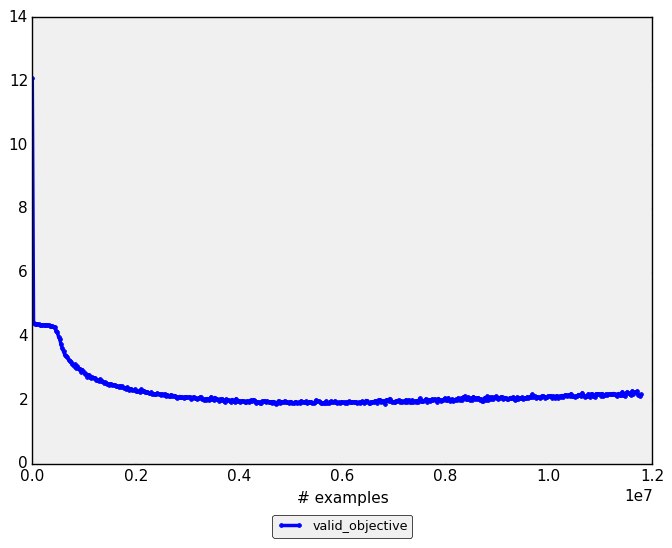

set x_axis to example
A. learning_rate
B. momentum
C. total_seconds_last_epoch
D. train_h1_kernel_norms_max
E. train_h1_kernel_norms_mean
F. train_h1_kernel_norms_min
G. train_h1_max_x_max_u
H. train_h1_max_x_mean_u
I. train_h1_max_x_min_u
J. train_h1_mean_x_max_u
K. train_h1_mean_x_mean_u
L. train_h1_mean_x_min_u
M. train_h1_min_x_max_u
N. train_h1_min_x_mean_u
O. train_h1_min_x_min_u
P. train_h1_range_x_max_u
Q. train_h1_range_x_mean_u
R. train_h1_range_x_min_u
S. train_h2_kernel_norms_max
T. train_h2_kernel_norms_mean
U. train_h2_kernel_norms_min
V. train_h2_max_x_max_u
W. train_h2_max_x_mean_u
X. train_h2_max_x_min_u
Y. train_h2_mean_x_max_u
Z. train_h2_mean_x_mean_u
BA. train_h2_mean_x_min_u
BB. train_h2_min_x_max_u
BC. train_h2_min_x_mean_u
BD. train_h2_min_x_min_u
BE. train_h2_range_x_max_u
BF. train_h2_range_x_mean_u
BG. train_h2_range_x_min_u
BH. train_h3_kernel_norms_max
BI. train_h3_kernel_norms_mean
BJ. train_h3_kernel_norms_min
BK. train_h3_max_x_max_u
BL. train_h3_max_x_m

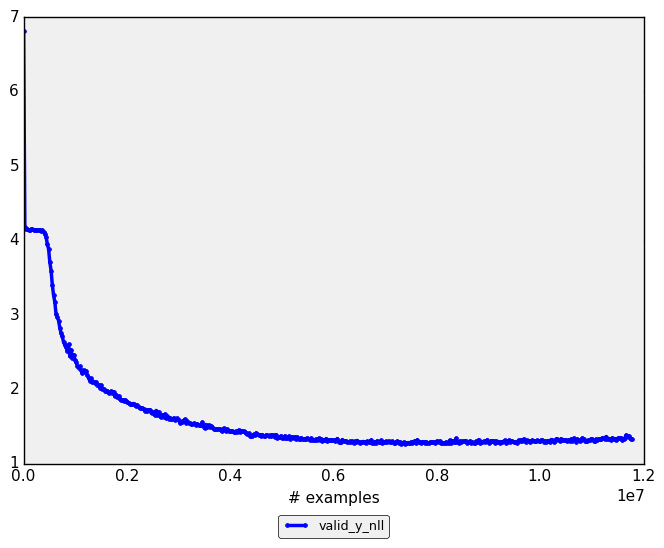

set x_axis to example
A. learning_rate
B. momentum
C. total_seconds_last_epoch
D. train_h1_kernel_norms_max
E. train_h1_kernel_norms_mean
F. train_h1_kernel_norms_min
G. train_h1_max_x_max_u
H. train_h1_max_x_mean_u
I. train_h1_max_x_min_u
J. train_h1_mean_x_max_u
K. train_h1_mean_x_mean_u
L. train_h1_mean_x_min_u
M. train_h1_min_x_max_u
N. train_h1_min_x_mean_u
O. train_h1_min_x_min_u
P. train_h1_range_x_max_u
Q. train_h1_range_x_mean_u
R. train_h1_range_x_min_u
S. train_h2_kernel_norms_max
T. train_h2_kernel_norms_mean
U. train_h2_kernel_norms_min
V. train_h2_max_x_max_u
W. train_h2_max_x_mean_u
X. train_h2_max_x_min_u
Y. train_h2_mean_x_max_u
Z. train_h2_mean_x_mean_u
BA. train_h2_mean_x_min_u
BB. train_h2_min_x_max_u
BC. train_h2_min_x_mean_u
BD. train_h2_min_x_min_u
BE. train_h2_range_x_max_u
BF. train_h2_range_x_mean_u
BG. train_h2_range_x_min_u
BH. train_h3_kernel_norms_max
BI. train_h3_kernel_norms_mean
BJ. train_h3_kernel_norms_min
BK. train_h3_max_x_max_u
BL. train_h3_max_x_m

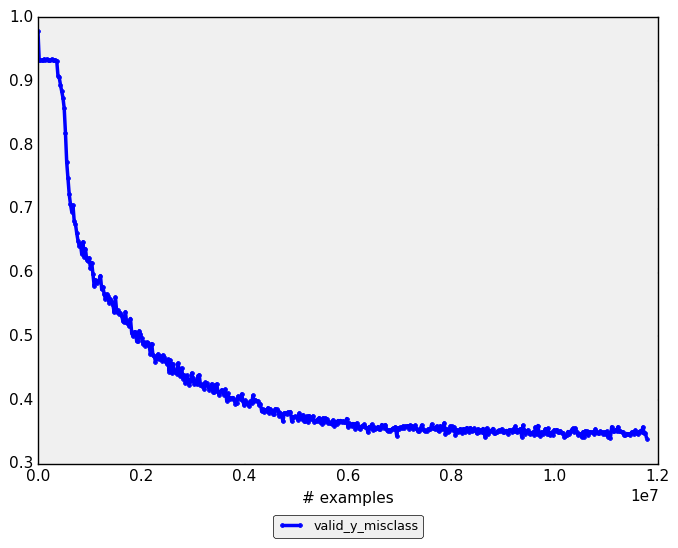

set x_axis to example
A. learning_rate
B. momentum
C. total_seconds_last_epoch
D. train_h1_kernel_norms_max
E. train_h1_kernel_norms_mean
F. train_h1_kernel_norms_min
G. train_h1_max_x_max_u
H. train_h1_max_x_mean_u
I. train_h1_max_x_min_u
J. train_h1_mean_x_max_u
K. train_h1_mean_x_mean_u
L. train_h1_mean_x_min_u
M. train_h1_min_x_max_u
N. train_h1_min_x_mean_u
O. train_h1_min_x_min_u
P. train_h1_range_x_max_u
Q. train_h1_range_x_mean_u
R. train_h1_range_x_min_u
S. train_h2_kernel_norms_max
T. train_h2_kernel_norms_mean
U. train_h2_kernel_norms_min
V. train_h2_max_x_max_u
W. train_h2_max_x_mean_u
X. train_h2_max_x_min_u
Y. train_h2_mean_x_max_u
Z. train_h2_mean_x_mean_u
BA. train_h2_mean_x_min_u
BB. train_h2_min_x_max_u
BC. train_h2_min_x_mean_u
BD. train_h2_min_x_min_u
BE. train_h2_range_x_max_u
BF. train_h2_range_x_mean_u
BG. train_h2_range_x_min_u
BH. train_h3_kernel_norms_max
BI. train_h3_kernel_norms_mean
BJ. train_h3_kernel_norms_min
BK. train_h3_max_x_max_u
BL. train_h3_max_x_m

In [11]:
%run ~/repos/pylearn2/pylearn2/scripts/plot_monitor.py /disk/scratch/neuroglycerin/models/alexnet_based.pkl.backup

Unfortunately, it's difficult to view the weights in an IPython notebook (and we get the above problems with user input above) and the devs [don't want to fix it][pl2issue] because they don't like IPython notebooks. So we need to hack around this problem.

The hack I've made is to define their environment variable `PYLEARN2_VIEWER_COMMAND` to be a shell script that just uses [ImageMagick][im] to rewrite the file (whatever it is) to a file in `~/tmp` called `pylearnplot.png`. Then, we can just use [IPython's rich display system][ip] to show it in the notebook.

[pl2issue]: https://github.com/lisa-lab/pylearn2/issues/1034
[im]: http://www.imagemagick.org/
[ip]: http://nbviewer.ipython.org/github/ipython/ipython/blob/1.x/examples/notebooks/Part%205%20-%20Rich%20Display%20System.ipynb

In [12]:
%env PYLEARN2_VIEWER_COMMAND=/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/image_hack.sh

env: PYLEARN2_VIEWER_COMMAND=/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/image_hack.sh


In [13]:
!echo $PYLEARN2_VIEWER_COMMAND

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work/image_hack.sh


In [14]:
%run ~/repos/pylearn2/pylearn2/scripts/show_weights.py /disk/scratch/neuroglycerin/models/alexnet_based.pkl.backup

making weights report
loading model
loading done
smallest enc weight magnitude: 7.74973341322e-06
mean enc weight magnitude: 0.0863215103745
max enc weight magnitude: 1.04721748829


In [15]:
from IPython.display import Image

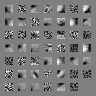

In [16]:
def plot_recent_pylearn2():
    pl2plt = Image(filename="/afs/inf.ed.ac.uk/user/s08/s0805516/tmp/pylearnplot.png", width=500)
    return pl2plt
plot_recent_pylearn2()

Looking at these, quite a few of the weight matrices seems to be quite noisy. Maybe they've learned something about the texture of the classes? Anyway, this was just to show that we can investigate the weights like this in a notebook. Looking closely at the weights is a job for another time.

Normalisation
=====

Taking a break from how to use Pylearn2, this notebook is also about looking at what Normalisation can do for us. We might as well inspect by eye the difference between images normalised by pixel and images normalised globally.

Loading some images into our Pylearn2 dataset class for two different cases. First, we have to prepare two run settings files:

In [18]:
import neukrill_net.utils as utils

In [148]:
!cp run_settings/alexnet_based.json run_settings/alexnet_based_norm_pixel.json

In [149]:
import os
import copy

In [150]:
settings = utils.Settings("settings.json")
bypixel = utils.load_run_settings("run_settings/alexnet_based_norm_pixel.json",settings)
byglobal = copy.deepcopy(bypixel)
byglobal['run_settings_path'] = os.path.abspath("run_settings/alexnet_based_norm_global.json")
bypixel['preprocessing']['normalise'] = {"global_or_pixel":"pixel"}
byglobal['preprocessing']['normalise'] = {"global_or_pixel":"global"}
utils.save_run_settings(byglobal)
utils.save_run_settings(bypixel)

In [151]:
import neukrill_net.dense_dataset as dense
reload(dense)

<module 'neukrill_net.dense_dataset' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/dense_dataset.pyc'>

In [145]:
# force recompile
import neukrill_net.image_processing
reload(neukrill_net.image_processing)

<module 'neukrill_net.image_processing' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/image_processing.py'>

In [146]:
global_data = dense.DensePNGDataset(run_settings=byglobal['run_settings_path'],verbose=True)

Applying normalisation: global


In [152]:
pixel_data = dense.DensePNGDataset(run_settings=bypixel['run_settings_path'],verbose=True)

Applying normalisation: pixel
Applying pixel-wise normalisation


The normalisation statistics have now been saved to run settings json, and we can look at them if we want to:

In [161]:
!cat run_settings/alexnet_based_norm_pixel.json

{
    "augmentation_factor":1,
    "filename":"alexnet_based_norm_pixel",
    "final_shape":[
        48,
        48
    ],
    "model type":"pylearn2",
    "modeldir":"/disk/scratch/neuroglycerin/models",
    "pickle abspath":"/disk/scratch/neuroglycerin/models/alexnet_based_norm_pixel.pkl",
    "preprocessing":{
        "normalise":{
            "global_or_pixel":"pixel",
            "mu":{
                "(0, 0)":0.9807952059667816,
                "(0, 1)":0.98973486432202984,
                "(0, 10)":0.9874850675900948,
                "(0, 11)":0.98740896702778236,
                "(0, 12)":0.98720651596826325,
                "(0, 13)":0.98717504341953832,
                "(0, 14)":0.98707215070156384,
                "(0, 15)":0.98687027153704809,
                "(0, 16)":0.98679753938061354,
                "(0, 17)":0.98675479686548151,
                "(0, 18)":0.98665363365862691,
                "(0, 19)":0.98681208509863494,
                "(0, 2)":0.98935695303652027

Now that the data is loaded we can have a look at these images with [Holoviews][hl] (it's from Edinburgh!).

[hl]: https://ioam.github.io/holoviews/index.html

In [153]:
import numpy as np

In [154]:
np.random.seed(42)
random_indexes = np.random.randint(low=0,high=global_data.X.shape[0],size=20)
global_images = global_data.get_topological_view(
                    global_data.X[random_indexes,:]).reshape(20,48,48)

Image
      I     : Image.Image   (z)
      II    : Image.Image   (z)
      III   : Image.Image   (z)
      IV    : Image.Image   (z)
      V     : Image.Image   (z)
      VI    : Image.Image   (z)
      VII   : Image.Image   (z)
      VIII  : Image.Image   (z)
      IX    : Image.Image   (z)
      X     : Image.Image   (z)
      XI    : Image.Image   (z)
      XII   : Image.Image   (z)
      XIII  : Image.Image   (z)
      XIV   : Image.Image   (z)
      XV    : Image.Image   (z)
      XVI   : Image.Image   (z)
      XVII  : Image.Image   (z)
      XVIII : Image.Image   (z)
      XIX   : Image.Image   (z)
      XX    : Image.Image   (z)
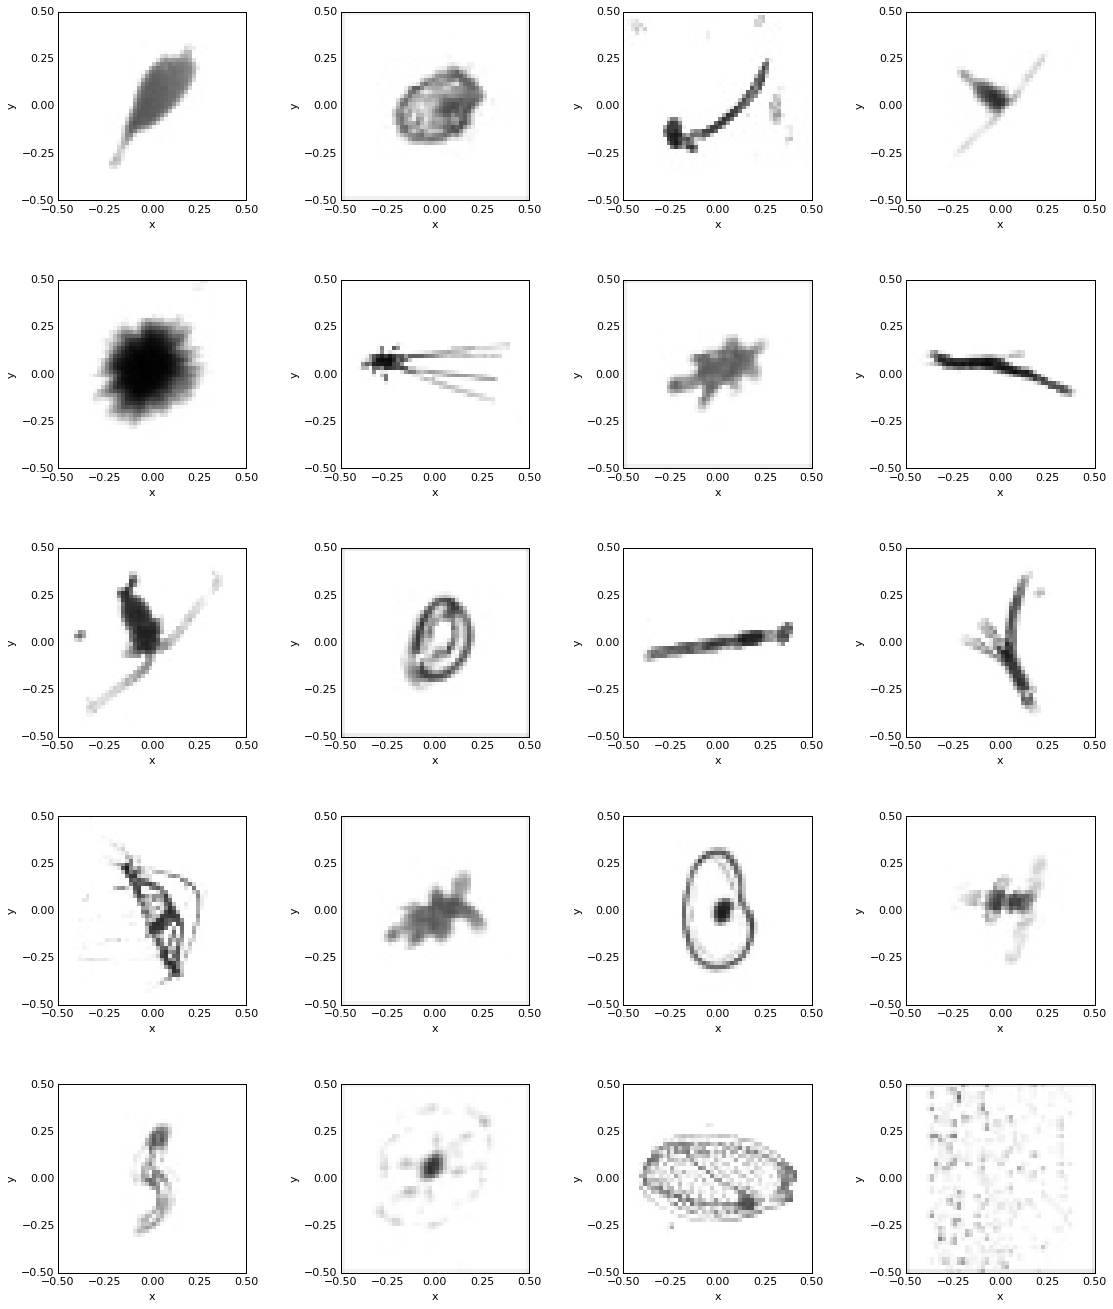

In [155]:
%opts Image style(cmap='gray')
channels = hl.Image(global_images[0])
for i in global_images[1:,:,:]:
    channels = channels + hl.Image(i)
# this is so easy it should be illegal
channels

Global images are just scaled by a single value, so we'd expect them to look the same. There's no reason to expect that for images scaled over the pixel values though:

In [156]:
np.random.seed(42)
random_indexes = np.random.randint(low=0,high=pixel_data.X.shape[0],size=20)
pixel_images = pixel_data.get_topological_view(
                    pixel_data.X[random_indexes,:]).reshape(20,48,48)

Image
      I     : Image.Image   (z)
      II    : Image.Image   (z)
      III   : Image.Image   (z)
      IV    : Image.Image   (z)
      V     : Image.Image   (z)
      VI    : Image.Image   (z)
      VII   : Image.Image   (z)
      VIII  : Image.Image   (z)
      IX    : Image.Image   (z)
      X     : Image.Image   (z)
      XI    : Image.Image   (z)
      XII   : Image.Image   (z)
      XIII  : Image.Image   (z)
      XIV   : Image.Image   (z)
      XV    : Image.Image   (z)
      XVI   : Image.Image   (z)
      XVII  : Image.Image   (z)
      XVIII : Image.Image   (z)
      XIX   : Image.Image   (z)
      XX    : Image.Image   (z)
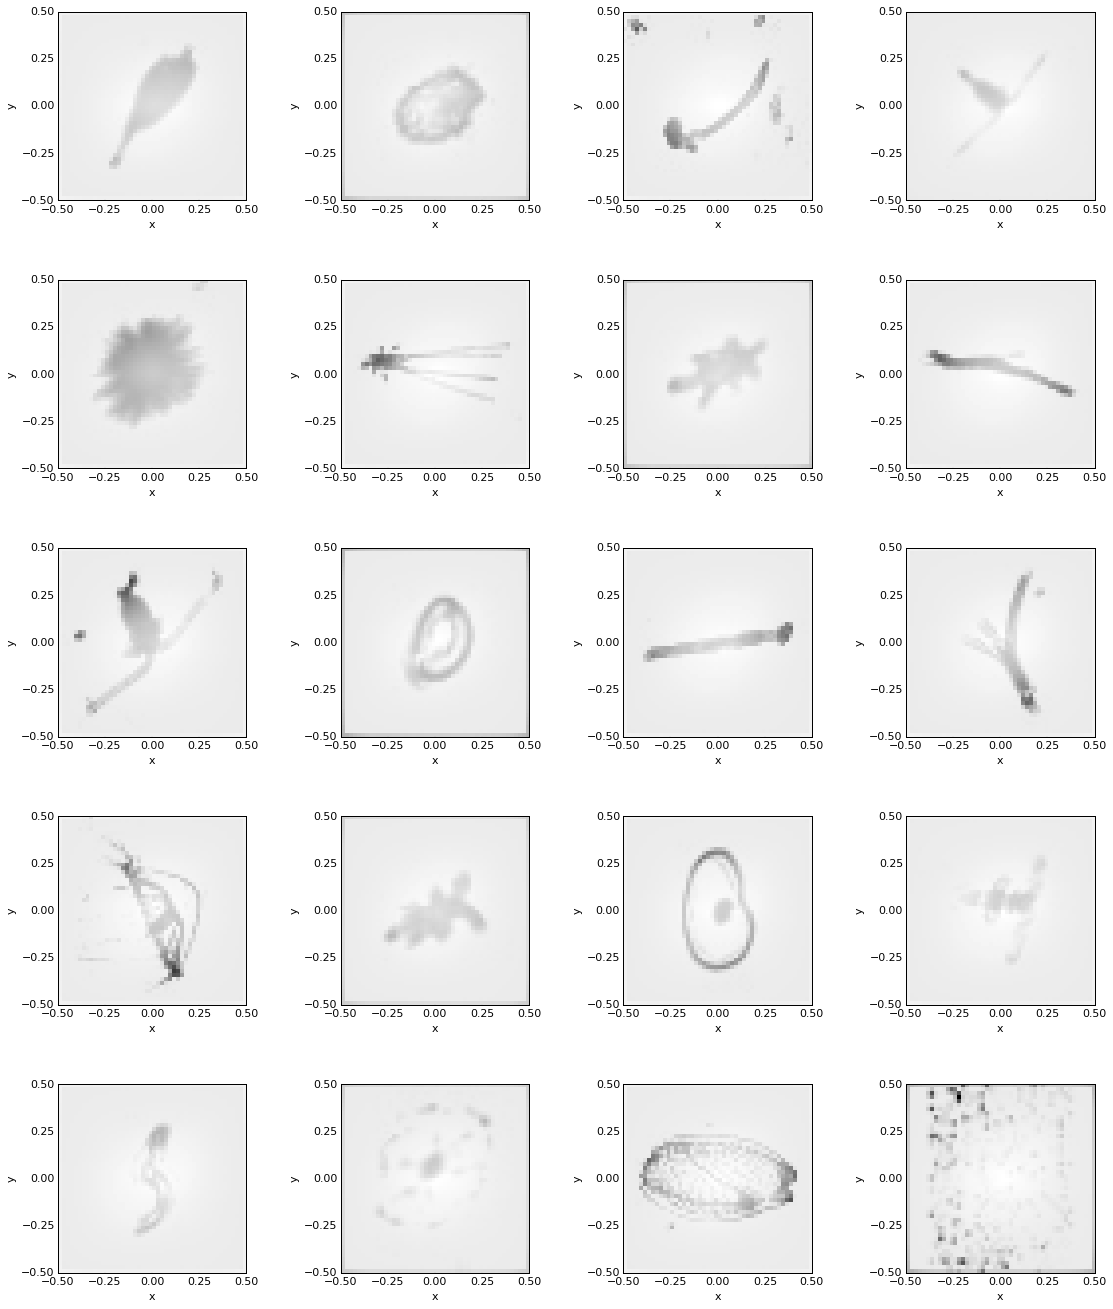

In [157]:
channels = hl.Image(pixel_images[0])
for i in pixel_images[1:,:,:]:
    channels = channels + hl.Image(i)
channels

It's easy to see the difference. There's a washout in the middle of images compared with the outside because so little happens at the edges that when something _does_ happen it doesn't get squashed.

In [158]:
import matplotlib.pyplot as plt

('Max', 0.31255826933187614)
('Min', -6.6099986906559627)
('Mean', -1.08585851115198e-15)
('Stdev', 1.0)


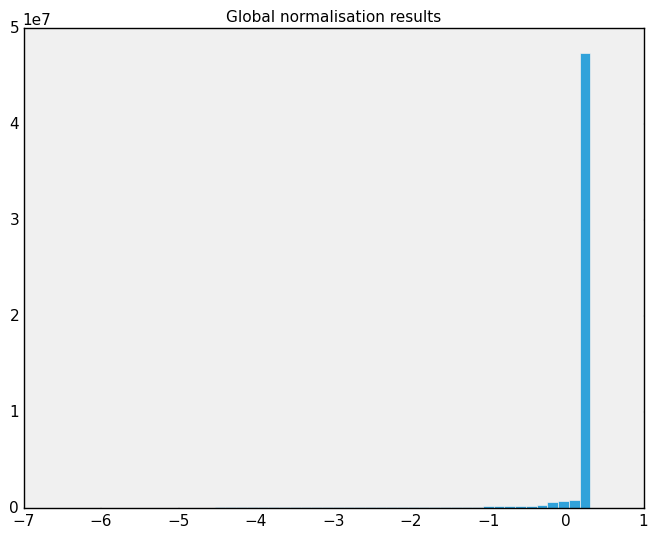

In [159]:
data = global_data.X
print("Max",np.max(data))
print("Min",np.min(data))
print("Mean",np.mean(data))
print("Stdev",np.sqrt(np.var(data)))
_ = plt.hist(np.ravel(data),bins=50)
plt.title("Global normalisation results")

('Max', 1.1513339147312567)
('Min', -68.6217779241979)
('Mean', 1.6430570170280674e-16)
('Stdev', 0.99999999999999933)


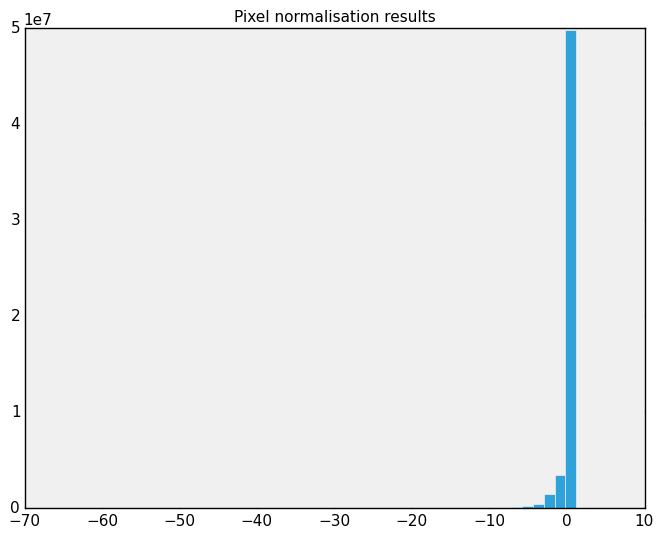

In [160]:
data = pixel_data.X
print("Max",np.max(data))
print("Min",np.min(data))
print("Mean",np.mean(data))
print("Stdev",np.sqrt(np.var(data)))
_ = plt.hist(np.ravel(data),bins=50)
plt.title("Pixel normalisation results")

Similar distributions, but getting some massive negative values on some of these pixels. At this point all we can do is try to train a model with them and see if we get better results than without scaling.

Running a model
=====

We're going to be running two models, using a utility called `longjob`. If you leave a job running on an active ssh connection then it will be deemed inactive after a period of time (12 hours?) and you'll suddenly stop being able to write anything. Using `longjob` this won't happen. This notebook server is being run through `longjob` for this reason.

> longjob is a wrapper script which simplifies the task of running jobs which require
> access to valid kerberos credentials for a longer period than the default ticket
> length (18 hours). The most common reason for this is so that a job can continue to
> access the AFS file system after the user’s initial ticket has expired.

Another useful utility if you're not in a notebook, running jobs through the shell is [screen][]. Using this it's possible to keep a shell open without being connected to it. You can run something in a shell then disconnect from it and leave it running in the background, then come back to it later. Simple usage in our case:

```bash
screen -D -R <session_name>
```

Where `<session_name>` is whatever name you want to give your shell session. Then you can use `ctrl-a + d` to detach and leave it running.

We want to run two nets on different GPUs. One for global and one for pixel-wise normalisation. The two run settings files will be an input to the general-purpose training script `train.py`. To get the help message for `train.py`:

[screen]: https://www.gnu.org/software/screen/

In [165]:
%run train.py -h

usage: train.py [-h] [-f] [-v] [run_settings]

Train a model and store apickled model file.

positional arguments:
  run_settings  Path to run settings json file.

optional arguments:
  -h, --help    show this help message and exit
  -f            Force overwrite of model files/submission csvs/anything else.
  -v            Run verbose.


Can't figure out how to send off longjobs from IPython notebooks yet. So the two commands I'm running are:

```bash
longjob -28day -c "python train.py run_settings/alexnet_based_norm_global.json" > /disk/scratch/neuroglycerin/logs/norm_global.log
```

and

```bash
longjob -28day -c "python train.py run_settings/alexnet_based_norm_pixel.json" > /disk/scratch/neuroglycerin/logs/norm_pixel.log
```

These were started in a screen session we can see with the following command:

In [167]:
!screen -ls


	2418.ipy	(Detached)
	33993.longjobs	(Detached)
2 Sockets in /var/run/screen/S-s0805516.



Because we're writing to these logs we can check the most recent progress by just tailing the logs:

In [186]:
!tail -n 20 /disk/scratch/neuroglycerin/logs/norm_global.log

	valid_h5_range_x_mean_u: 0.684866130352
	valid_h5_range_x_min_u: 0.0
	valid_h5_row_norms_max: 0.877702474594
	valid_h5_row_norms_mean: 0.763510167599
	valid_h5_row_norms_min: 0.703453838825
	valid_objective: 3.12544417381
	valid_term_0: 2.94545531273
	valid_term_1_weight_decay: 0.192011252046
	valid_y_col_norms_max: 1.76487243176
	valid_y_col_norms_mean: 1.59867763519
	valid_y_col_norms_min: 1.47974860668
	valid_y_max_max_class: 0.592624187469
	valid_y_mean_max_class: 0.221788734198
	valid_y_min_max_class: 0.0387513153255
	valid_y_misclass: 0.646739006042
	valid_y_nll: 2.67557621002
	valid_y_row_norms_max: 0.710210502148
	valid_y_row_norms_mean: 0.54859995842
	valid_y_row_norms_min: 0.457096040249
Saving to /disk/scratch/neuroglycerin/models/alexnet_based_norm_global.pkl...


In [187]:
!tail -n 20 /disk/scratch/neuroglycerin/logs/norm_pixel.log

	valid_h5_row_norms_mean
	valid_h5_row_norms_min
	valid_objective
	valid_term_0
	valid_term_1_weight_decay
	valid_y_col_norms_max
	valid_y_col_norms_mean
	valid_y_col_norms_min
	valid_y_max_max_class
	valid_y_mean_max_class
	valid_y_min_max_class
	valid_y_misclass
	valid_y_nll
	valid_y_row_norms_max
	valid_y_row_norms_mean
	valid_y_row_norms_min
Compiling accum...
graph size: 491
graph size: 487
Compiling accum done. Time elapsed: 0:02:30.649570


We can also check how the GPUs are doing with the same command as at the start:

In [188]:
!nvidia-smi

Thu Feb 26 02:35:40 2015       
+------------------------------------------------------+                       
| NVIDIA-SMI 340.24     Driver Version: 340.24         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40c          Off  | 0000:02:00.0     Off |                    0 |
| 30%   64C    P0    97W / 235W |    365MiB / 11519MiB |     91%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 0000:04:00.0     Off |                    0 |
| 26%   53C    P0    62W / 235W |    145MiB / 11519MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

One is running on GPU 0 and one is running on GPU 2. The above were run shortly after starting the training. After leaving it overnight we get the following logs:

In [189]:
!tail -n 20 /disk/scratch/neuroglycerin/logs/norm_global.log

	valid_h5_range_x_min_u: 0.0
	valid_h5_row_norms_max: 1.01608288288
	valid_h5_row_norms_mean: 0.740970134735
	valid_h5_row_norms_min: 0.678165793419
	valid_objective: 1.8276052475
	valid_term_0: 1.65191495419
	valid_term_1_weight_decay: 0.203093662858
	valid_y_col_norms_max: 1.93657040596
	valid_y_col_norms_mean: 1.70017051697
	valid_y_col_norms_min: 1.43537795544
	valid_y_max_max_class: 0.996362328529
	valid_y_mean_max_class: 0.687002122402
	valid_y_min_max_class: 0.150911450386
	valid_y_misclass: 0.332201063633
	valid_y_nll: 1.18461406231
	valid_y_row_norms_max: 0.897549271584
	valid_y_row_norms_mean: 0.581896603107
	valid_y_row_norms_min: 0.448730647564
Saving to /disk/scratch/neuroglycerin/models/alexnet_based_norm_global.pkl...
retrying with pickle


In [200]:
!tail -n 200 /disk/scratch/neuroglycerin/logs/norm_pixel.log

	train_y_max_max_class: 0.995562672615
	train_y_mean_max_class: 0.815425693989
	train_y_min_max_class: 0.294000834227
	train_y_misclass: 0.0736606568098
	train_y_nll: 0.3095087111
	train_y_row_norms_max: 0.855372488499
	train_y_row_norms_mean: 0.586683392525
	train_y_row_norms_min: 0.454553991556
	training_seconds_this_epoch: 39.1973304749
	valid_h1_kernel_norms_max: 1.93649971485
	valid_h1_kernel_norms_mean: 0.927059650421
	valid_h1_kernel_norms_min: 0.327536135912
	valid_h1_max_x_max_u: 64.1715164185
	valid_h1_max_x_mean_u: 4.57075119019
	valid_h1_max_x_min_u: 0.091011762619
	valid_h1_mean_x_max_u: 4.3826880455
	valid_h1_mean_x_mean_u: 0.421219885349
	valid_h1_mean_x_min_u: 0.0108055388555
	valid_h1_min_x_max_u: 0.193720579147
	valid_h1_min_x_mean_u: 0.000374322815333
	valid_h1_min_x_min_u: 0.0
	valid_h1_range_x_max_u: 64.1715164185
	valid_h1_range_x_mean_u: 4.57037687302
	valid_h1_range_x_min_u: 0.0907139778137
	valid_h2_kernel_norms_max: 1.93649935722
	valid_h2_kernel_norms_mean: 1

So that file just stops halfway through writing? Has someone filled up scratch again?

In [193]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
/dev/sda1        39G   24G   14G  64% /
tmpfs            32G  288K   32G   1% /dev/shm
/dev/sda3       7.7G  6.2G  1.2G  85% /var/cache/afs
/dev/sda4       855G  805G  6.9G 100% /disk/scratch
AFS             8.6G     0  8.6G   0% /afs
/dev/gpfsdev    6.4T  3.6T  2.9T  56% /gpfs


Looks like it was probably filled during the night and has now been cleaned up a bit.

Results logging
=====

_Pending_ section on how these results are logged back into the run settings. (Pending code to do that).

Analysing these networks
=========

Looking into the pickle files, seeing which is better and why.

Prediction
====

So we've trained these models and now we want to make a submission to the Kaggle leaderboard. For this, we use our general purpose `test.py` script (I would've preferred to call it `predict.py` at this point). It takes a stored pickle file, loads the test data and runs forward passes of the network to generate predictions for every test point. It then writes these results to gzipped csv file. All we have to do is specify which run settings file to use.

Doing this for both of these:

In [202]:
%run test.py run_settings/alexnet_based_norm_global.json
%run test.py run_settings/alexnet_based_norm_pixel.json

Waiting 0.5 seconds and trying again
Waiting 1.0 seconds and trying again
Waiting 2.0 seconds and trying again
Waiting 4.0 seconds and trying again
Waiting 8.0 seconds and trying again
Waiting 16.0 seconds and trying again
Waiting 32.0 seconds and trying again
Waiting 64.0 seconds and trying again
Waiting 128.0 seconds and trying again


KeyboardInterrupt: 

Waiting 0.5 seconds and trying again
Waiting 1.0 seconds and trying again
Waiting 2.0 seconds and trying again
Waiting 4.0 seconds and trying again
Waiting 8.0 seconds and trying again
Waiting 16.0 seconds and trying again
Waiting 32.0 seconds and trying again
Waiting 64.0 seconds and trying again


KeyboardInterrupt: 

Looks like those pickle files are corrupted then. Normally that would have run ok.

Submission
---------

Anyway, _if that had worked_ you could then copy that file back to your computer with `scp` or `rsync` and submitted it to the Kaggle web form to see what score you'd get on the public leaderboard.